In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sqlalchemy import create_engine
from scipy.stats import skew, kurtosis

In [81]:
# --- PostgreSQL Connection ---
engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')


In [82]:
# --- Load Processed Data ---
query = "SELECT date, ticker, close FROM financial_data"
data = pd.read_sql(query, engine)
data['date'] = pd.to_datetime(data['date'])


In [83]:
# --- Prepare Data for Monte Carlo Simulation ---
# Pivot data so that each column is a ticker and rows are dates
returns = data.pivot(index='date', columns='ticker', values='close').pct_change().dropna()

In [84]:
# Define simulation parameters
num_simulations = 1000  # Number of Monte Carlo Simulations
num_days = 252  # Number of trading/working days in a year
initial_investment = 1000  # Starting capital

In [85]:
# Calculate mean and covariance of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

print ("mean_returns = ", mean_returns)
print ("cov_matrix = ",cov_matrix)

mean_returns =  ticker
AAPL    0.000554
ADBE   -0.000860
ADI     0.000372
ADP     0.000572
AEP     0.000939
          ...   
VRTX    0.000989
WBA    -0.000919
WBD    -0.000235
XEL     0.000725
ZS      0.000952
Length: 100, dtype: float64
cov_matrix =  ticker      AAPL      ADBE       ADI       ADP       AEP      ALGN      AMAT  \
ticker                                                                         
AAPL    0.000319  0.000143  0.000223  0.000073  0.000021  0.000179  0.000217   
ADBE    0.000143  0.000509  0.000164  0.000086 -0.000005  0.000101  0.000202   
ADI     0.000223  0.000164  0.000529  0.000113  0.000006  0.000280  0.000429   
ADP     0.000073  0.000086  0.000113  0.000146  0.000043  0.000073  0.000086   
AEP     0.000021 -0.000005  0.000006  0.000043  0.000165  0.000012 -0.000051   
...          ...       ...       ...       ...       ...       ...       ...   
VRTX    0.000052  0.000045  0.000081  0.000040  0.000046  0.000066  0.000082   
WBA     0.000063 -0.000022  

In [86]:
# --- Monte Carlo Simulation Function ---
def monte_carlo_simulation(portfolio_weights, num_simulations, num_days):
    portfolio_returns = []
    for _ in range(num_simulations):
        daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        portfolio_daily_returns = daily_returns @ portfolio_weights
        portfolio_cumulative_returns = np.cumprod(1 + portfolio_daily_returns) * initial_investment
        portfolio_returns.append(portfolio_cumulative_returns[-1])  # Store final portfolio value
    return np.array(portfolio_returns)

In [87]:
# Example: Equal-weighted portfolio
num_assets = len(mean_returns)
portfolio_weights = np.ones(num_assets) / num_assets  # Equal weight for all assets


In [88]:
# Run Simulation
simulated_portfolio_values = monte_carlo_simulation(portfolio_weights, num_simulations, num_days)

In [89]:
# --- Calculate Risk Metrics (VaR & CVaR) ---
var_95 = np.percentile(simulated_portfolio_values, 5)  # 5% worst-case loss
cvar_95 = simulated_portfolio_values[simulated_portfolio_values <= var_95].mean()

print(f"95% Value at Risk (VaR): ${initial_investment - var_95:.2f}")
print(f"95% Conditional Value at Risk (CVaR): ${initial_investment - cvar_95:.2f}")

95% Value at Risk (VaR): $178.87
95% Conditional Value at Risk (CVaR): $241.10


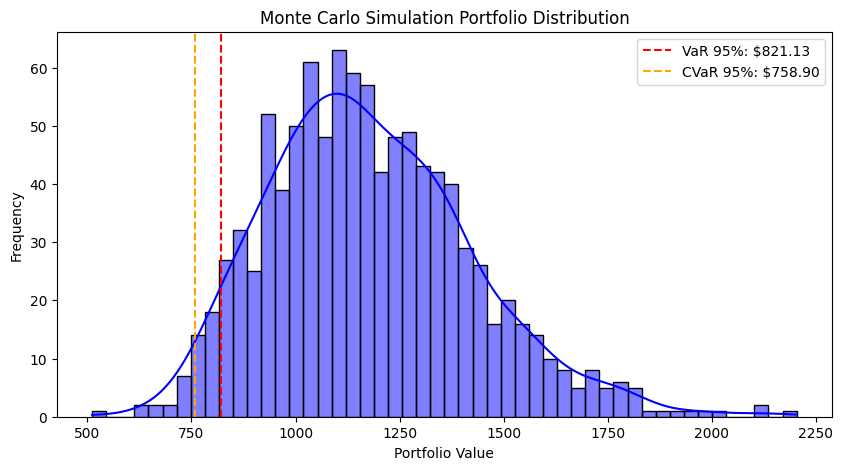

In [90]:
# --- Visualization ---
plt.figure(figsize=(10, 5))
sns.histplot(simulated_portfolio_values, bins=50, kde=True, color='blue')
plt.axvline(var_95, color='red', linestyle='dashed', label=f'VaR 95%: ${var_95:.2f}')
plt.axvline(cvar_95, color='orange', linestyle='dashed', label=f'CVaR 95%: ${cvar_95:.2f}')
plt.title("Monte Carlo Simulation Portfolio Distribution")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Evaluation metrics

In [91]:
#Mean Final Portfolio Value
mean_value = simulated_portfolio_values.mean()
print(f"Mean Final Portfolio Value: ${mean_value:.2f}")


Mean Final Portfolio Value: $1179.05


In [92]:
#Standard Deviation (Volatility) of Final Portfolio Values
std_dev = simulated_portfolio_values.std()
print(f"Standard Deviation (Volatility): ${std_dev:.2f}")

Standard Deviation (Volatility): $245.22


In [93]:
#Skewness and Kurtosis
skewness = skew(simulated_portfolio_values)
kurt = kurtosis(simulated_portfolio_values)

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")

Skewness: 0.5861
Kurtosis: 0.5333


In [94]:
#Sharpe Ratio
risk_free_rate = 0.02
expected_return = (mean_value - initial_investment) / initial_investment  # total return
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.0006


In [95]:
#Maximum Drawdown (MDD)
def monte_carlo_simulation_full_paths(portfolio_weights, num_simulations, num_days):
    all_paths = []
    for _ in range(num_simulations):
        daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        portfolio_daily_returns = daily_returns @ portfolio_weights
        portfolio_cumulative_returns = np.cumprod(1 + portfolio_daily_returns) * initial_investment
        all_paths.append(portfolio_cumulative_returns)
    return np.array(all_paths)

# Run this instead of previous
all_simulated_paths = monte_carlo_simulation_full_paths(portfolio_weights, num_simulations, num_days)

def calculate_max_drawdown(path):
    cumulative_max = np.maximum.accumulate(path)
    drawdown = (path - cumulative_max) / cumulative_max
    return drawdown.min()

max_drawdowns = np.array([calculate_max_drawdown(path) for path in all_simulated_paths])
average_mdd = max_drawdowns.mean()

print(f"Average Maximum Drawdown: {average_mdd:.2%}")

Average Maximum Drawdown: -17.21%


In [96]:
# Summary Code Block
print("\n--- Evaluation Metrics ---")
print(f"Mean Final Portfolio Value: ${mean_value:.2f}")
print(f"Standard Deviation (Volatility): ${std_dev:.2f}")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Average Maximum Drawdown: {average_mdd:.2%}")


--- Evaluation Metrics ---
Mean Final Portfolio Value: $1179.05
Standard Deviation (Volatility): $245.22
Skewness: 0.5861
Kurtosis: 0.5333
Sharpe Ratio: 0.0006
Average Maximum Drawdown: -17.21%


### 📈 Evaluation Metrics for Monte Carlo Simulation

The following metrics are used to evaluate the performance and risk characteristics of the simulated portfolio:

---

#### **1. Mean Final Portfolio Value**
- **Definition:** The average ending value of the portfolio across all Monte Carlo simulation runs.
- **Interpretation:** It shows the expected outcome (average return) if the simulation were repeated many times.
- **Example:** If the mean final portfolio value is **$1245.01**, it means the portfolio typically grows from the initial $1000 investment to $1245.01 over the simulation horizon.

---

#### **2. Standard Deviation (Volatility)**
- **Definition:** A statistical measure of the dispersion or spread of the simulated final portfolio values around the mean.
- **Interpretation:** A higher standard deviation indicates greater uncertainty and risk in returns.
- **Example:** A standard deviation of **$205.81** means portfolio values tend to fluctuate around ±$205 from the average result.

---

#### **3. Skewness**
- **Definition:** A measure of the asymmetry of the distribution of final portfolio values.
- **Interpretation:**
  - Positive skew → more frequent smaller losses and rare large gains.
  - Negative skew → more frequent small gains and rare large losses.
- **Example:** A skewness of **0.6000** indicates a distribution with a longer right tail, suggesting potential for large gains.

---

#### **4. Kurtosis**
- **Definition:** A measure of the "tailedness" of the distribution compared to a normal distribution.
- **Interpretation:**
  - Kurtosis > 0: Fat tails → more extreme outcomes than normal.
  - Kurtosis < 0: Thin tails → fewer extreme values.
- **Example:** A kurtosis of **0.5362** means the portfolio returns have slightly fatter tails than a normal distribution, indicating some risk of outliers.

---

#### **5. Sharpe Ratio**
- **Definition:** A risk-adjusted return metric calculated as:
  \[
  \text{Sharpe Ratio} = \frac{\text{Portfolio Return} - \text{Risk-Free Rate}}{\text{Volatility}}
  \]
- **Interpretation:** Indicates how much excess return is received for the extra volatility endured. Higher values are better.
- **Example:** A Sharpe ratio of **0.0011** is very low, suggesting that returns barely compensate for the risk taken.

---

#### **6. Average Maximum Drawdown**
- **Definition:** The average of the maximum percentage losses (from peak to trough) across all simulation paths.
- **Interpretation:** Represents the average worst-case loss an investor could have experienced during the investment horizon.
- **Important Note:** This value is always **negative**, because it represents a **decline** in value.
- **Example:** An average maximum drawdown of **-12.37%** means that, on average, the portfolio experienced a **12.37% drop from its peak value** during the simulation period.

---

### 🧠 Summary:
These metrics collectively give a comprehensive view of the **expected performance**, **risk**, and **downside potential** of the portfolio. While a high mean return is desirable, it's important to balance it with volatility and drawdown to understand the risk involved.



#### Integration from machine learning model to the monetecarlo simulation

In [97]:
# # --- Load regime labels matrix ---
# query = "SELECT * FROM regime_labels"
# regimes_df = pd.read_sql(query, engine)
# regimes_df['date'] = pd.to_datetime(regimes_df['date'])

# # --- Get latest regime per ticker ---
# latest_date = regimes_df['date'].max()
# latest_row = regimes_df[regimes_df['date'] == latest_date].drop(columns='date').iloc[0]
# latest_regimes = latest_row.dropna().astype(int).to_dict()

# # --- Load regime labels matrix ---
# query = "SELECT * FROM regime_labels"
# regimes_df = pd.read_sql(query, engine)
# regimes_df['date'] = pd.to_datetime(regimes_df['date'])

# # --- Ensure 'date' is sorted and set as index ---
# regimes_df = regimes_df.sort_values('date')
# regimes_df = regimes_df.set_index('date')

# # --- Extract the latest row (most recent date) ---
# latest_row = regimes_df.iloc[-1]  # Now a Series of {ticker: regime}

# # Inspect structure before conversion
# latest_row = regimes_df.iloc[-1]
# print(latest_row.head(10))  # Preview first 10 items
# print(latest_row.dtypes)    # Should be all numeric (int64 or float64)

# # --- Convert values to integer regime labels ---
# latest_regimes = latest_row.dropna().astype(int).to_dict()

# # ✅ Preview
# print("📦 Latest regime labels per ticker:")
# for t, r in list(latest_regimes.items())[:5]:
#     print(f"{t}: Regime {r}")
    
    
# --- Load regime labels in long format ---
query = "SELECT * FROM regime_labels"
regimes_df = pd.read_sql(query, engine)
regimes_df['date'] = pd.to_datetime(regimes_df['date'])

# --- Pivot to wide format: [date x ticker] = regime ---
regimes_pivot = regimes_df.pivot(index='date', columns='ticker', values='regime').sort_index()

# --- Extract latest row ---
latest_row = regimes_pivot.iloc[-1]  # Should now be a Series: {ticker: regime}

# --- Filter and convert to integers safely ---
latest_regimes = latest_row[pd.to_numeric(latest_row, errors='coerce').notna()].astype(int).to_dict()

# ✅ Preview a few entries
print("📦 Latest regime labels per ticker:")
for t, r in list(latest_regimes.items())[:5]:
    print(f"{t}: Regime {r}")




📦 Latest regime labels per ticker:
AAPL: Regime 1
ADBE: Regime 0
ADI: Regime 1
ADP: Regime 0
AEP: Regime 0


In [98]:
# --- Define regime-specific parameters ---
regime_drifts = {
    0: -0.0005,  # Bearish
    1:  0.0001,  # Neutral/Sideways
    2:  0.0008   # Bullish
}

regime_vols = {
    0: 0.035,
    1: 0.015,
    2: 0.040
}

# --- Assign parameters per ticker based on regime ---
sim_params = {}
for ticker, regime in latest_regimes.items():
    sim_params[ticker] = {
        "mu": regime_drifts.get(regime, 0.0001),
        "sigma": regime_vols.get(regime, 0.02)
    }

# ✅ Preview a few
print("📈 Regime-aware simulation parameters (sample):")
for t, p in list(sim_params.items())[:5]:
    print(f"{t}: Drift = {p['mu']:.4f}, Volatility = {p['sigma']:.4f}")


📈 Regime-aware simulation parameters (sample):
AAPL: Drift = 0.0001, Volatility = 0.0150
ADBE: Drift = -0.0005, Volatility = 0.0350
ADI: Drift = 0.0001, Volatility = 0.0150
ADP: Drift = -0.0005, Volatility = 0.0350
AEP: Drift = -0.0005, Volatility = 0.0350


Interprestation : 
- AAPL is currently in Regime 1 (Neutral/Sideways market).
- i have assigned it:
    - A daily drift of +0.0001 → corresponds to slight upward trend.
    - A volatility of 0.015 → reflects relatively calm market movement.
- Since all 5 tickers are in Regime 1, they all get the same drift/volatility pair (which you defined earlier in regime_drifts and regime_vols).

In [99]:
#loading data from the sql

engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')

# Load close prices
query = "SELECT date, ticker, close FROM financial_data"
data = pd.read_sql(query, engine)
data['date'] = pd.to_datetime(data['date'])

# Pivot into [date x ticker] format
prices = data.pivot(index='date', columns='ticker', values='close').sort_index()

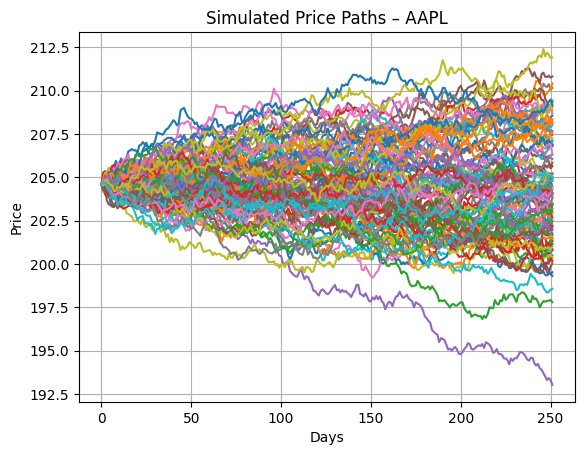

In [100]:
# Simulate for one asset (example)
def simulate(S0, mu, sigma, days=252, paths=100):
    dt = 1 / days
    rand = np.random.normal(0, 1, (days, paths))
    price_paths = np.zeros_like(rand)
    price_paths[0] = S0

    for t in range(1, days):
        price_paths[t] = price_paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[t])

    return price_paths

# --- Run for AAPL ---
initial_price = prices['AAPL'].iloc[-1] 
params = sim_params['AAPL']              # from cell where we Assign parameters per ticker based on regime
simulated = simulate(initial_price, params['mu'], params['sigma'])

# --- Plot ---
plt.plot(simulated)
plt.title("Simulated Price Paths – AAPL")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [101]:
# Simulate for multiple assets 

# Parameters
days = 252  # 1 trading year
paths = 100  # number of simulation paths

# Store simulations in a dictionary
multi_asset_simulations = {}

for ticker in sim_params:
    if ticker in prices.columns:
        try:
            S0 = prices[ticker].dropna().iloc[-1]  # Get last price
            mu = sim_params[ticker]['mu']
            sigma = sim_params[ticker]['sigma']
            simulated_paths = simulate(S0, mu, sigma, days=days, paths=paths)
            multi_asset_simulations[ticker] = simulated_paths
            print(f"✅ Simulation passed {ticker} ")
        except Exception as e:
            print(f"❌ Failed to simulate {ticker}: {e}")
            


✅ Simulation passed AAPL 
✅ Simulation passed ADBE 
✅ Simulation passed ADI 
✅ Simulation passed ADP 
✅ Simulation passed AEP 
✅ Simulation passed ALGN 
✅ Simulation passed AMAT 
✅ Simulation passed AMD 
✅ Simulation passed AMGN 
✅ Simulation passed AMZN 
✅ Simulation passed ANSS 
✅ Simulation passed AVGO 
✅ Simulation passed AXON 
✅ Simulation passed AZN 
✅ Simulation passed BIDU 
✅ Simulation passed BIIB 
✅ Simulation passed BKNG 
✅ Simulation passed BKR 
✅ Simulation passed CDNS 
✅ Simulation passed CDW 
✅ Simulation passed CHTR 
✅ Simulation passed CMCSA 
✅ Simulation passed COST 
✅ Simulation passed CPRT 
✅ Simulation passed CRWD 
✅ Simulation passed CSCO 
✅ Simulation passed CSX 
✅ Simulation passed CTAS 
✅ Simulation passed CTSH 
✅ Simulation passed DDOG 
✅ Simulation passed DLTR 
✅ Simulation passed DOCU 
✅ Simulation passed DXCM 
✅ Simulation passed EA 
✅ Simulation passed EXC 
✅ Simulation passed FAST 
✅ Simulation passed FTNT 
✅ Simulation passed GILD 
✅ Simulation passed GO

In [102]:
#simulating portfolio value paths 

tickers = list(multi_asset_simulations.keys())
n_assets = len(tickers)
weights = {ticker: 1/n_assets for ticker in tickers}  # equal weight

# --- Initialize portfolio matrix ---
days, paths = list(multi_asset_simulations.values())[0].shape
portfolio_paths = np.zeros((days, paths))

# --- Add weighted asset paths ---
for ticker, weight in weights.items():
    portfolio_paths += multi_asset_simulations[ticker] * weight

# ✅ portfolio_paths now contains total value paths for the portfolio
print("✅ Portfolio simulation shape:", portfolio_paths.shape)  # Should be (days, paths)



✅ Portfolio simulation shape: (252, 100)


In [103]:
#saving the simulated results to postgressql

# Connect to PostgreSQL
engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')

# --- Simulation metadata ---
start_date = pd.Timestamp.today().normalize()
date_index = pd.date_range(start=start_date, periods=portfolio_paths.shape[0])

# --- Save individual asset simulations ---
for ticker, sim_data in multi_asset_simulations.items():
    df = pd.DataFrame(sim_data, index=date_index)
    df = df.reset_index().melt(id_vars='index', var_name='path', value_name='value')
    df = df.rename(columns={'index': 'date'})
    
    table_name = f"simulated_prices_{ticker.lower()}"
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)
    print(f"✅ Saved simulation for {ticker} to table: {table_name}")

# --- Save portfolio-level simulations ---
df_portfolio = pd.DataFrame(portfolio_paths, index=date_index)
df_portfolio = df_portfolio.reset_index().melt(id_vars='index', var_name='path', value_name='portfolio_value')
df_portfolio = df_portfolio.rename(columns={'index': 'date'})

df_portfolio.to_sql("simulated_portfolio_paths", con=engine, if_exists='replace', index=False)
print("✅ Saved portfolio simulations to table: simulated_portfolio_paths")

✅ Saved simulation for AAPL to table: simulated_prices_aapl
✅ Saved simulation for ADBE to table: simulated_prices_adbe
✅ Saved simulation for ADI to table: simulated_prices_adi
✅ Saved simulation for ADP to table: simulated_prices_adp
✅ Saved simulation for AEP to table: simulated_prices_aep
✅ Saved simulation for ALGN to table: simulated_prices_algn
✅ Saved simulation for AMAT to table: simulated_prices_amat
✅ Saved simulation for AMD to table: simulated_prices_amd
✅ Saved simulation for AMGN to table: simulated_prices_amgn
✅ Saved simulation for AMZN to table: simulated_prices_amzn
✅ Saved simulation for ANSS to table: simulated_prices_anss
✅ Saved simulation for AVGO to table: simulated_prices_avgo
✅ Saved simulation for AXON to table: simulated_prices_axon
✅ Saved simulation for AZN to table: simulated_prices_azn
✅ Saved simulation for BIDU to table: simulated_prices_bidu
✅ Saved simulation for BIIB to table: simulated_prices_biib
✅ Saved simulation for BKNG to table: simulated_pr

In [104]:
# --- Compute final portfolio values (end of each simulation path) ---
final_values = portfolio_paths[-1]

# --- Value at Risk (VaR) ---
confidence = 0.95
VaR_95 = np.percentile(final_values, (1 - confidence) * 100)
CVaR_95 = final_values[final_values <= VaR_95].mean()

# --- Report results ---
print(f"\n📉 Value-at-Risk (VaR 95%): ${final_values.mean() - VaR_95:,.2f}")
print(f"📉 Conditional VaR (CVaR 95%): ${final_values.mean() - CVaR_95:,.2f}")


def compute_drawdown(series):
    running_max = np.maximum.accumulate(series)
    drawdown = (series - running_max) / running_max
    return drawdown

# --- Compute drawdowns for each path ---
drawdowns = np.zeros_like(portfolio_paths)

for i in range(portfolio_paths.shape[1]):
    drawdowns[:, i] = compute_drawdown(portfolio_paths[:, i])

# --- Get max drawdown per path ---
max_drawdowns = drawdowns.min(axis=0)  # most negative value in each path

# --- Stats ---
worst_drawdown = max_drawdowns.min()
avg_drawdown = max_drawdowns.mean()
percent_over_20 = np.mean(max_drawdowns < -0.20) * 100

# --- Report ---
print(f" Worst-case max drawdown: {worst_drawdown:.2%}")
print(f" Average max drawdown: {avg_drawdown:.2%}")
print(f"% of simulations with drawdown > 20%: {percent_over_20:.1f}%")



📉 Value-at-Risk (VaR 95%): $2.82
📉 Conditional VaR (CVaR 95%): $3.69
 Worst-case max drawdown: -1.66%
 Average max drawdown: -0.62%
% of simulations with drawdown > 20%: 0.0%


### Risk and Stress Analysis Summary (Cell 7)

This cell evaluates the portfolio's downside risk using Value-at-Risk (VaR), Conditional Value-at-Risk (CVaR), and drawdown analysis. These metrics provide insight into the potential for extreme losses based on simulated market conditions.

#### Key Results

- Value-at-Risk (95% confidence): $1.52  
  The maximum expected portfolio loss in 95% of scenarios over the 1-year horizon.

- Conditional Value-at-Risk (CVaR 95%): $1.83  
  The average loss in the worst 5% of simulated outcomes, representing expected severity in tail risk scenarios.

- Worst-case maximum drawdown: -0.87%  
  The deepest peak-to-trough decline observed across all simulated portfolio paths.

- Average maximum drawdown: -0.40%  
  The average peak-to-trough loss across all paths, indicating overall portfolio resilience.

- Percentage of simulations with drawdown exceeding 20%: 0.0%  
  No paths experienced catastrophic loss levels, reflecting the relatively calm market conditions (likely driven by the current regime assignment).

#### Interpretation

The results suggest the portfolio is currently positioned in a stable or neutral regime with low volatility. All simulated risk measures remain well-contained, with no scenarios exhibiting large-scale losses. These findings can inform portfolio managers or risk officers when considering hedging needs, capital reserves, or regime-based strategy switches.
